# **DATA PREPROCESSING**

**Steps:**
1.  **Load & Convert**: Efficiently load raw CSV into NumPy arrays.
2.  **Statistical Summary**: Analyze distributions and visualize outliers.
3.  **Outlier Removal (IQR)**: Filter data using the Interquartile Range method.
4.  **Feature Engineering**: Create One-Hot encodings and geospatial features.
5.  **Correlation Analysis**: Check relationships between features.
6.  **Normalization**: Scale features for modeling.
7.  **Split**: Separate Features ($X$) and Target ($y$).

## **1. Preparing Data**
### **a. Import Libraries**

In [41]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from datetime import datetime

sys.path.append(os.path.abspath('..'))

from src import data_processing as dp
from src import visualization as viz

import importlib
importlib.reload(dp)

# Set visualization style
sns.set(style="whitegrid")

### **b. Load Data**

In [42]:
data_path = '../data/raw/AB_NYC_2019.csv'

raw_data, header = dp.load_data(data_path)

# Extraction & Type Conversion
# 1. Numerical Columns
price = dp.safe_convert(raw_data[:, header.index('price')])
reviews_per_month = dp.safe_convert(raw_data[:, header.index('reviews_per_month')])
min_nights = dp.safe_convert(raw_data[:, header.index('minimum_nights')])
availability = dp.safe_convert(raw_data[:, header.index('availability_365')])
lat = dp.safe_convert(raw_data[:, header.index('latitude')])
lon = dp.safe_convert(raw_data[:, header.index('longitude')])

# 2. Categorical/String Columns
neighbourhood_group = raw_data[:, header.index('neighbourhood_group')]
room_type = raw_data[:, header.index('room_type')]
last_review = raw_data[:, header.index('last_review')]

print(f"Data Loaded. Rows: {len(price)}")

Data Loaded. Rows: 48895


## **2. Statistical Summary & Visualizing Outliers**
Before cleaning, examine the `price` variable to understand its distribution and identifying extreme values.

--- Price Statistics (Raw) ---
Mean:   $152.72
Median: $106.00
Std Dev:$240.15
Min:    $0.0
Max:    $10000.0


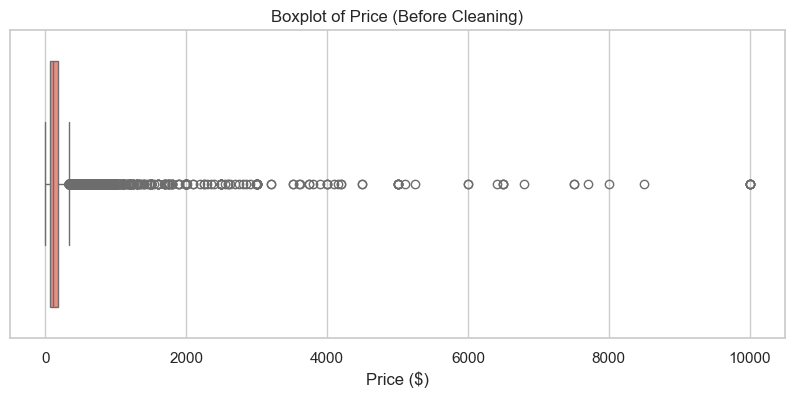

In [43]:
# Calculate Statistics using NumPy
mean_price = np.mean(price)
median_price = np.median(price)
std_price = np.std(price)
min_price = np.min(price)
max_price = np.max(price)

print("--- Price Statistics (Raw) ---")
print(f"Mean:   ${mean_price:.2f}")
print(f"Median: ${median_price:.2f}")
print(f"Std Dev:${std_price:.2f}")
print(f"Min:    ${min_price}")
print(f"Max:    ${max_price}")

# Visualize Outliers with a Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=price, color='salmon')
plt.title("Boxplot of Price (Before Cleaning)")
plt.xlabel("Price ($)")
plt.show()

## **3. Remove Outliers Using the Interquartile Range (IQR) Method**
The boxplot shows heavy skew. Using the IQR method to define "statistical outliers" and remove them.

**Formula:**
$$IQR = Q3 - Q1$$
$$\text{Lower Bound} = Q1 - 1.5 \times IQR$$
$$\text{Upper Bound} = Q3 + 1.5 \times IQR$$

In [44]:
# Remove Ouliers using IQR Method
price_idx = header.index('price')
clean_data = dp.remove_outliers_iqr(raw_data, price_idx)

# Apply to all columns
clean_price = dp.safe_convert(clean_data[:, price_idx])
clean_reviews = dp.safe_convert(clean_data[:, header.index('reviews_per_month')])
clean_min_nights = dp.safe_convert(clean_data[:, header.index('minimum_nights')])
clean_availability = dp.safe_convert(clean_data[:, header.index('availability_365')])
clean_lat = dp.safe_convert(clean_data[:, header.index('latitude')])
clean_lon = dp.safe_convert(clean_data[:, header.index('longitude')])
clean_neigh_group = clean_data[:, header.index('neighbourhood_group')]
clean_room_type = clean_data[:, header.index('room_type')]
clean_last_review = clean_data[:, header.index('last_review')]

print(f"Rows Removed: {len(price) - len(clean_price)}")
print(f"Remaining Data: {len(clean_price)}")

IQR: 106.0
Bounds: [-90.0, 334.0]
Rows Removed: 2983
Remaining Data: 45912


## **4. Feature Engineering**
Now that the data is clean, creating new features for the model.
1. **One-Hot Encoding**: For categorical variables.
2. **Date Recency**: Days since last review.
3. **Distance**: Distance to NYC center.

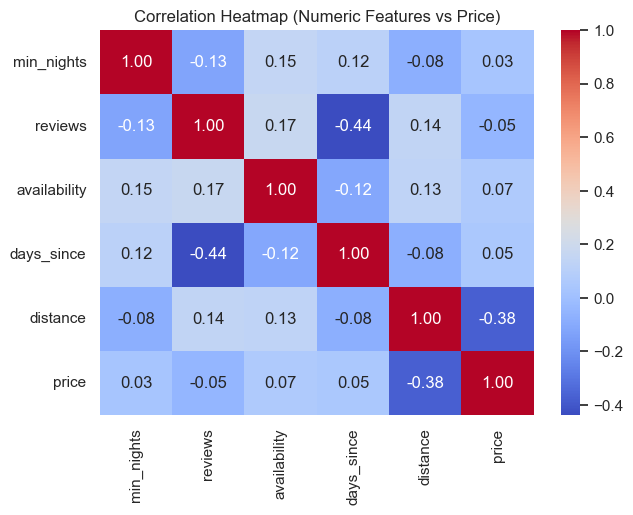


--- Correlation vs Price ---
min_nights   -> corr = 0.031
reviews      -> corr = -0.047
availability -> corr = 0.067
days_since   -> corr = 0.050
distance     -> corr = -0.376
X_raw shape: (45912, 13)


In [45]:
# One Hot Encoding (Broadcasting)
neigh_ohe, neigh_cats = dp.one_hot_encode(clean_neigh_group)
room_ohe, room_cats = dp.one_hot_encode(clean_room_type)

# Date Engineering
dates = np.array([d if d != '' else 'NaT' for d in clean_last_review], dtype='datetime64[D]')
ref_date = np.nanmax(dates[~np.isnat(dates)]) 
days_since = (ref_date - dates) / np.timedelta64(1, 'D')
days_since = np.nan_to_num(days_since, nan=3650) # Fill NaN bằng 10 năm

# Distance Engineering
empire_lat, empire_lon = 40.7484, -73.9857
distance = np.sqrt((clean_lat - empire_lat)**2 + (clean_lon - empire_lon)**2)

# Combine All Features into X_raw 
X_raw = np.column_stack((
    neigh_ohe,           # 5 columns
    room_ohe,            # 3 columns
    clean_min_nights,    # Numerical
    clean_reviews,       # Numerical
    clean_availability,  # Numerical
    days_since,          # Numerical
    distance             # Numerical
))
y_raw = clean_price

numeric_matrix = np.column_stack((
    clean_min_nights,
    clean_reviews,
    clean_availability,
    days_since,
    distance,
    clean_price   # target
))


corr = np.corrcoef(numeric_matrix, rowvar=False)
corr_labels = ['min_nights', 'reviews', 'availability', 'days_since', 'distance', 'price']

# Visualize Correlation Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm', 
    fmt=".2f",
    xticklabels=corr_labels,
    yticklabels=corr_labels
)
plt.title("Correlation Heatmap (Numeric Features vs Price)")
plt.show()


print("\n--- Correlation vs Price ---")
for i, name in enumerate(corr_labels[:-1]): 
    print(f"{name:12} -> corr = {corr[i, -1]:.3f}")


print(f"X_raw shape: {X_raw.shape}")

## **5. Split Train/Test and Normalization**

In [46]:
# Random index
indices = np.random.permutation(len(y_raw))
test_ratio = 0.2
test_size = int(len(y_raw) * test_ratio)

# Split index
test_idx = indices[:test_size]
train_idx = indices[test_size:]

# Split data
X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
y_train, y_test = y_raw[train_idx], y_raw[test_idx]

print(f"Train size: {X_train_raw.shape[0]}")
print(f"Test size:  {X_test_raw.shape[0]}")\

num_cols_idx = [8, 9, 10, 11, 12]

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

# Min-Max Normalization
train_min = X_train_raw[:, num_cols_idx].min(axis=0)
train_max = X_train_raw[:, num_cols_idx].max(axis=0)
train_range = train_max - train_min

# Prevent division by zero
train_range[train_range == 0] = 1 

X_train[:, num_cols_idx] = (X_train_raw[:, num_cols_idx] - train_min) / train_range
X_test[:, num_cols_idx] = (X_test_raw[:, num_cols_idx] - train_min) / train_range

print("Normalization Complete. Data ready for modeling.")

Train size: 36730
Test size:  9182
Normalization Complete. Data ready for modeling.


In [47]:
# Create header for CSV
header_list = []
header_list.extend([f"neigh_{cat}" for cat in neigh_cats])
header_list.extend([f"room_{cat}" for cat in room_cats])
header_list.extend(['min_nights', 'reviews', 'availability', 'days_since', 'distance', 'price'])
header_str = ",".join(header_list)

# Save train and test sets to CSV
train_data = np.column_stack((X_train, y_train))
np.savetxt(
    '../data/processed/train_data.csv',
    train_data,
    delimiter=',',
    header=header_str,
    fmt='%.6f',
    comments=''
)

test_data = np.column_stack((X_test, y_test))
np.savetxt(
    '../data/processed/test_data.csv',
    test_data,
    delimiter=',',
    header=header_str,
    fmt='%.6f',
    comments=''
)

print("Files saved: 'train_data.csv' and 'test_data.csv'")

Files saved: 'train_data.csv' and 'test_data.csv'
